Install Required Libraries

In [100]:
!pip install opendatasets
!pip install imbalanced-learn
!pip install scikit-learn

Download the Breast Cancer Dataset from Kaggle

In [101]:
import opendatasets as od

Download the dataset from Kaggle

In [102]:
od.download('https://www.kaggle.com/datasets/erdemtaha/cancer-data/data')

Skipping, found downloaded files in "./cancer-data" (use force=True to force download)


Import Libraries

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Load the Dataset

In [104]:
data = pd.read_csv('/content/cancer-data/Cancer_Data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Data Preprocessing and Feature Selection

Drop unnecessary columns and handle missing data

In [105]:
data = data.drop(['id', 'Unnamed: 32'], axis=1)

Display basic info about the dataset

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Encode the target column 'diagnosis' (B -> 0, M -> 1)

In [107]:
label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])

Display the first and last few rows of the encoded diagnosis

In [108]:
data['diagnosis'].head()  , data['diagnosis'].tail()

(0    1
 1    1
 2    1
 3    1
 4    1
 Name: diagnosis, dtype: int64,
 564    1
 565    1
 566    1
 567    1
 568    0
 Name: diagnosis, dtype: int64)

Check the distribution of benign and malignant cases

In [109]:
data['diagnosis'].value_counts()

,count
diagnosis,
0,357
1,212


## Data Visualization

Calculate the correlation matrix for all features

In [110]:
correlation_matrix = data.corr()

Plot the entire correlation matrix with x and y labels

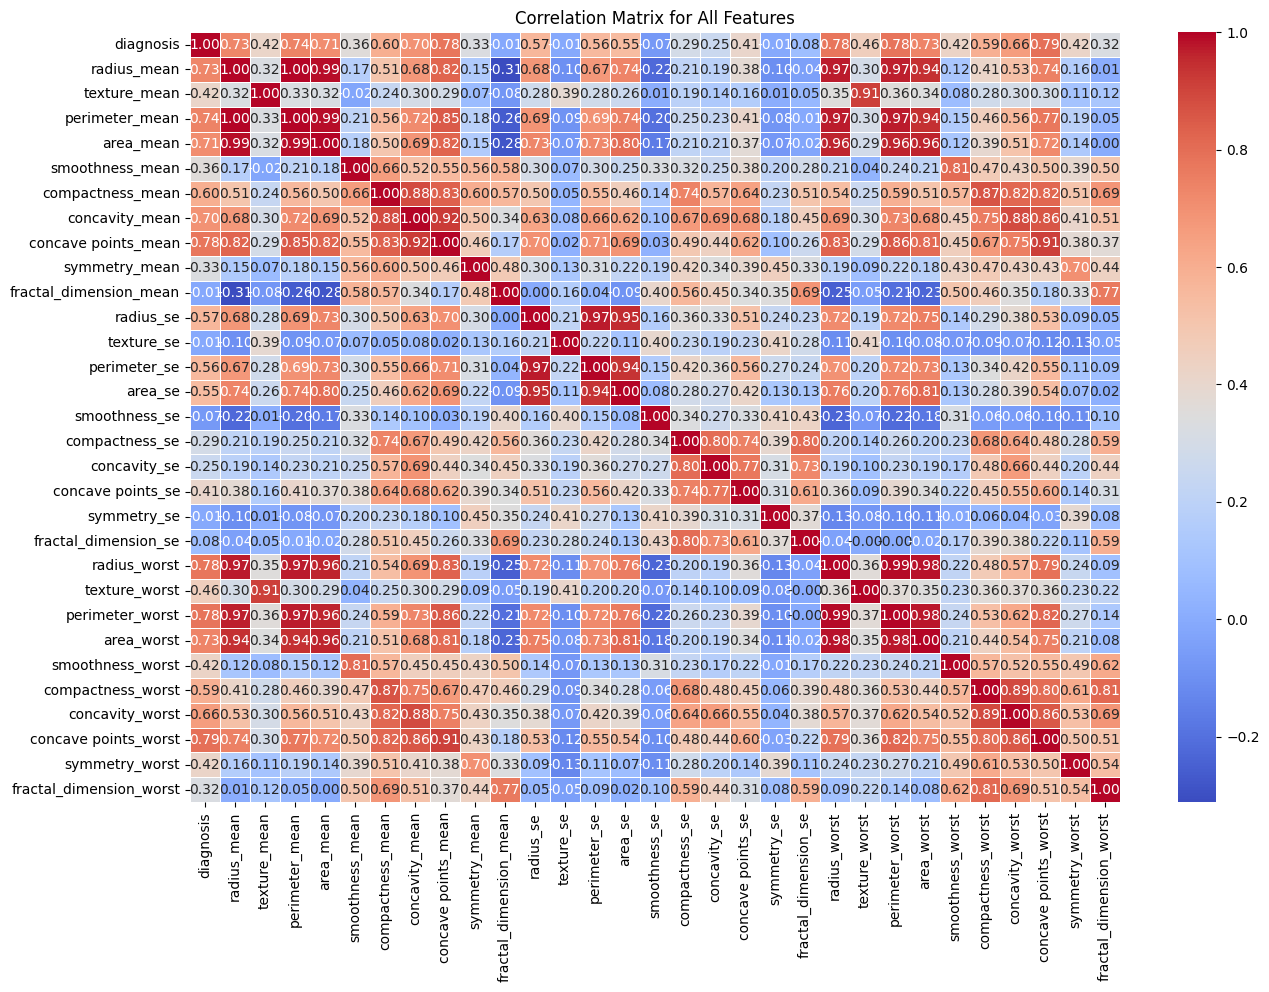

In [111]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for All Features')
plt.show()

## Feature Selection - Select features with correlation > 0.5

Use SelectKBest with ANOVA F-test to select top 10 features

In [112]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

Show selected features

In [113]:
selected_columns = X.columns[selector.get_support()]
print(f"Selected Features: {selected_columns}")

Selected Features: Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')


Create a new correlation matrix for only the selected features

In [114]:
selected_correlation_matrix = data[selected_columns].corr()

Plot the correlation heatmap for the selected features

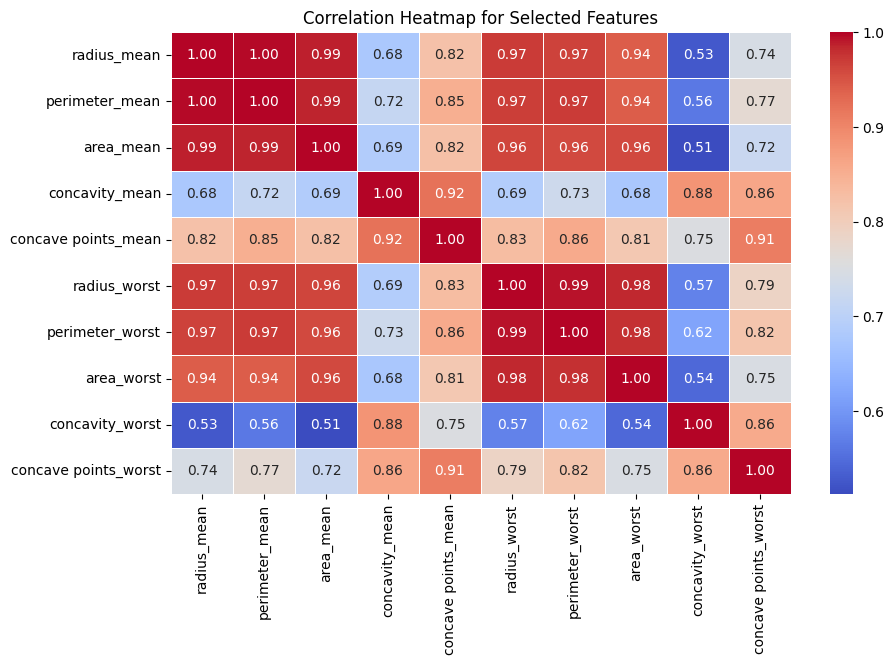

In [115]:
plt.figure(figsize=(10, 6))
sns.heatmap(selected_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Selected Features')
plt.show()

## Handle Class Imbalance using SMOTE

In [116]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_new, y)

Check class distribution after oversampling

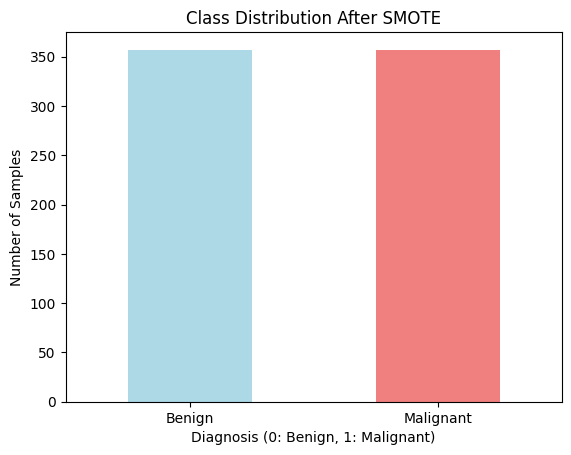

In [117]:
# Check class distribution after oversampling
class_distribution = pd.Series(y_resampled).value_counts()
class_distribution.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Diagnosis (0: Benign, 1: Malignant)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)
plt.show()

## Standardize the Features

In [118]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

Reshape for Conv1D (3D shape: samples, timesteps, features)

In [119]:
X_reshaped = np.expand_dims(X_scaled, axis=2)

## Split the Data into Training and Testing Sets

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_resampled, test_size=0.2, random_state=42)

## Build the CNN Model

In [121]:
model = Sequential()

# Add first convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Add second convolutional layer (adjusted kernel size to 2)
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

# Add third convolutional layer (adjusted kernel size and no further pooling)
model.add(Conv1D(filters=256, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Flatten the data and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compile the Model

In [122]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
# Get the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 8, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 3, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 1, 256)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,609 (330.50 KB)

 Trainable params: 83,713 (327.00 KB)

 Non-trainable params: 896 (3.50 KB)

## Set Early Stopping and Learning Rate Scheduler

In [124]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

## Train the Model

In [125]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6290 - loss: 2.4720 - val_accuracy: 0.8112 - val_loss: 2.3631 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7915 - loss: 2.1785 - val_accuracy: 0.8741 - val_loss: 2.3144 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8454 - loss: 2.0742 - val_accuracy: 0.8811 - val_loss: 2.2644 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8866 - loss: 2.0018 - val_accuracy: 0.9021 - val_loss: 2.2145 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8651 - loss: 1.9662 - val_accuracy: 0.8951 - val_loss: 2.1660 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8979 - loss: 1.8586 - val_accuracy: 0.8951 - val_loss: 2.1169 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8760

## Model Evaluation

Plot accuracy and loss

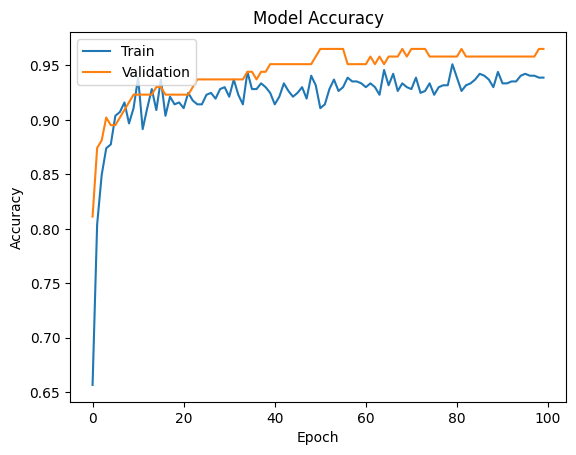

In [126]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

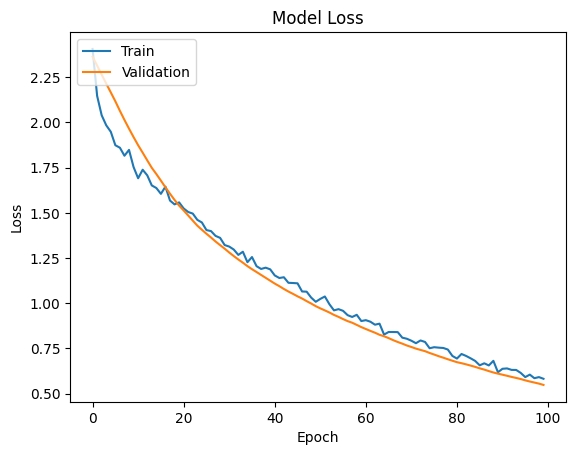

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate and Print Classification Report

In [128]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Confusion Matrix

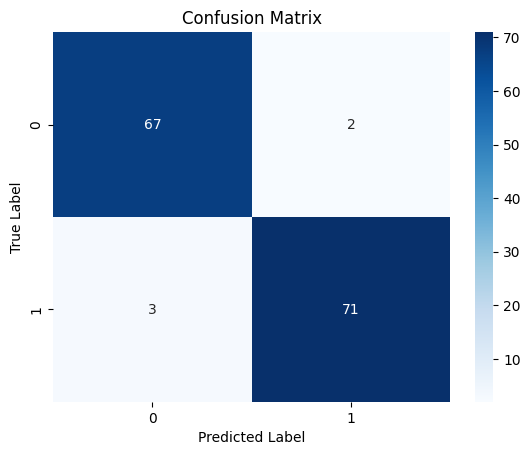

In [129]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

ROC Curve

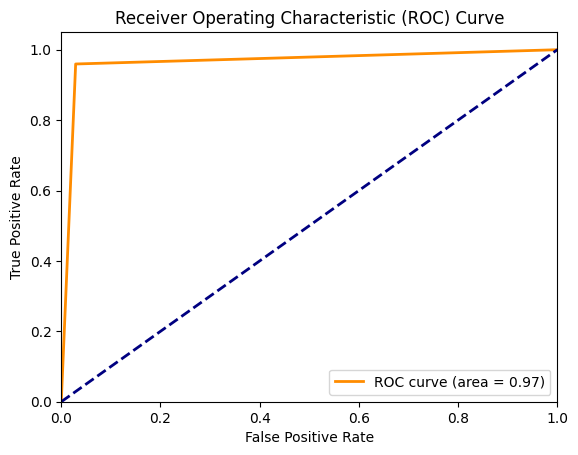

In [130]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Calculate Accuracy, Precision, Recall, and F1-Score

In [131]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9650
Precision: 0.9726
Recall: 0.9595
F1 Score: 0.9660


## Save the Model

In [132]:
model.save('breast_cancer_cnn_model.h5')